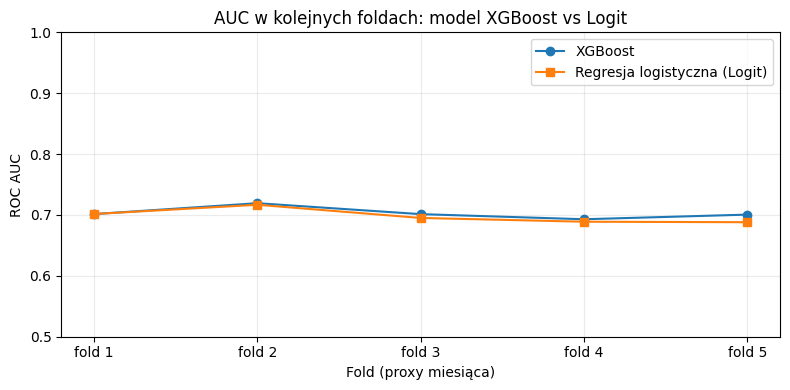

Średnie AUC — XGBoost: 0.7031 | Logit: 0.6981 | Δ=0.0051


In [ ]:
# ===== Rys. 5.5.a — AUC po foldach (XGB/LGBM vs Logit) =====
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) USTAW ŚCIEŻKĘ BAZOWĄ DO ARTEFAKTÓW
# Przykład:
# ROOT = Path(r"C:\Users\...\PRACA MAGISTERSKA\pliki\artifacts")
ROOT = Path(r"C:\Users\lukasz.wrobel\Desktop\PRACA MAGISTERSKA\pliki\artifacts")
assert ROOT.exists(), f"Nie znaleziono katalogu: {ROOT}"

# 2) Ścieżki do per-fold metryk
ART = {
    "Logit": {
        "dir": ROOT / "artifacts_43",
        "cv_fold": ["cv_fold_metrics.csv"],  # lista możliwych nazw (pierwsza która istnieje)
    },
    "XGBoost": {
        "dir": ROOT / "artifacts_46_gbm",
        "cv_fold": ["cv_fold_metrics_xgb.csv", "cv_fold_metrics.csv"],
    },
    "LightGBM": {
        "dir": ROOT / "artifacts_46_gbm",
        "cv_fold": ["cv_fold_metrics_lgb.csv", "cv_fold_metrics.csv"],
    },
}

def load_cv_auc_per_fold(folder: Path, candidates: list[str]) -> pd.Series:
    """
    Wczytuje AUC po foldach (kolumna 'AUC') z pierwszego istniejącego pliku.
    Zwraca serię długości K (foldy); jeśli brak 'AUC', rzuca ValueError.
    """
    for fname in candidates:
        f = folder / fname
        if f.exists():
            df = pd.read_csv(f)
            if "AUC" not in df.columns:
                raise ValueError(f"Plik {f} nie zawiera kolumny 'AUC'.")
            # jeżeli mamy kolumnę 'valid_month' wykorzystaj ją do etykiet
            if "valid_month" in df.columns:
                return pd.Series(df["AUC"].values, index=df["valid_month"].astype(str).tolist())
            # inaczej użyj numeru foldu (1..K)
            return pd.Series(df["AUC"].values, index=[f"fold {i+1}" for i in range(len(df))])
    raise FileNotFoundError(
        f"Nie znaleziono pliku z metrykami foldów w {folder} (szukano: {candidates})."
    )

# 3) Wybór modelu „produkcyjnego”
prod_name = None
try:
    auc_xgb = load_cv_auc_per_fold(ART["XGBoost"]["dir"], ART["XGBoost"]["cv_fold"])
    prod_name, auc_prod = "XGBoost", auc_xgb
except Exception:
    try:
        auc_lgb = load_cv_auc_per_fold(ART["LightGBM"]["dir"], ART["LightGBM"]["cv_fold"])
        prod_name, auc_prod = "LightGBM", auc_lgb
    except Exception as e:
        raise RuntimeError("Brak metryk foldów dla XGBoost/LightGBM. Upewnij się, że pliki istnieją.") from e

auc_logit = load_cv_auc_per_fold(ART["Logit"]["dir"], ART["Logit"]["cv_fold"])

# 4) Ujednolicenie indeksów (etykiet osi X); jeśli różne, przyjmujemy wspólne wg kolejności foldów
if not auc_prod.index.equals(auc_logit.index):
    # zrób listę o długości min(K_prod, K_logit)
    k = min(len(auc_prod), len(auc_logit))
    auc_prod = auc_prod.iloc[:k]
    auc_logit = auc_logit.iloc[:k]
    x_labels = [f"fold {i+1}" for i in range(k)]
else:
    x_labels = list(auc_prod.index)

# 5) Rysunek
plt.figure(figsize=(8,4))
plt.plot(x_labels, auc_prod.values, marker="o", label=f"{prod_name}")
plt.plot(x_labels, auc_logit.values, marker="s", label="Regresja logistyczna (Logit)")
plt.ylim(0.5, 1.0)
plt.xlabel("Fold (proxy miesiąca)")
plt.ylabel("ROC AUC")
plt.title("AUC w kolejnych foldach: model XGBoost vs Logit")
plt.legend()
plt.grid(True, alpha=0.25)
plt.tight_layout()

OUT = ROOT / "podsumowanie_wyników"
OUT.mkdir(exist_ok=True, parents=True)
plt.savefig(OUT / "Rys_AUC_vs_fold_prod_vs_logit.png", dpi=200)
plt.show()

print(f"Średnie AUC — {prod_name}: {auc_prod.mean():.4f} | Logit: {auc_logit.mean():.4f} | Δ={auc_prod.mean()-auc_logit.mean():.4f}")


In [ ]:
# ===== Tabela 5.5 — Stabilność w czasie i segmentach =====
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

# --- 1) USTAW ŚCIEŻKĘ BAZOWĄ DO ARTEFAKTÓW (tę samą co dla rysunku) ---
ROOT = Path(r"C:\Users\lukasz.wrobel\Desktop\PRACA MAGISTERSKA\pliki\artifacts")
assert ROOT.exists(), f"Nie znaleziono katalogu: {ROOT}"

ART = {
    "Logit": {
        "dir": ROOT / "artifacts_43",
        "cv_fold": ["cv_fold_metrics.csv"],
        "oot_scored": ["oot_scored.csv"],                    # opcjonalnie
    },
    "XGBoost": {
        "dir": ROOT / "artifacts_46_gbm",
        "cv_fold": ["cv_fold_metrics_xgb.csv",
                    "cv_fold_metrics.csv"],
        "oot_scored": ["oot_scored_xgb.csv", "oot_scored.csv"],  # opcjonalnie
    },
    "LightGBM": {
        "dir": ROOT / "artifacts_46_gbm",
        "cv_fold": ["cv_fold_metrics_lgb.csv",
                    "cv_fold_metrics.csv"],
        "oot_scored": ["oot_scored_lgb.csv", "oot_scored.csv"],  # opcjonalnie
    },
}

OUT = ROOT / "podsumowanie_wyników"
OUT.mkdir(exist_ok=True, parents=True)

def load_cv_auc_per_fold(folder: Path, candidates: list[str]) -> pd.Series:
    """Czyta AUC po foldach (kolumna 'AUC') z pierwszego istniejącego pliku."""
    for fname in candidates:
        f = folder / fname
        if f.exists():
            df = pd.read_csv(f)
            if "AUC" not in df.columns:
                raise ValueError(f"Plik {f} nie ma kolumny 'AUC'.")
            if "valid_month" in df.columns:
                return pd.Series(df["AUC"].values,
                                 index=df["valid_month"].astype(str).tolist(),
                                 name="AUC")
            return pd.Series(df["AUC"].values,
                             index=[f"fold {i+1}" for i in range(len(df))],
                             name="AUC")
    raise FileNotFoundError(f"Brak plików foldowych w {folder} (szukano: {candidates}).")

# --- 2) Wybierz automatycznie model produkcyjny (XGB preferowany; jeśli brak, LGB) ---
prod_name = None
try:
    auc_prod = load_cv_auc_per_fold(ART["XGBoost"]["dir"], ART["XGBoost"]["cv_fold"])
    prod_name = "XGBoost"
except Exception:
    try:
        auc_prod = load_cv_auc_per_fold(ART["LightGBM"]["dir"], ART["LightGBM"]["cv_fold"])
        prod_name = "LightGBM"
    except Exception as e:
        raise RuntimeError("Brak metryk foldów dla XGBoost/LightGBM.") from e

auc_logit = load_cv_auc_per_fold(ART["Logit"]["dir"], ART["Logit"]["cv_fold"])

# Ujednolić długość, gdyby liczba foldów była różna
k = min(len(auc_prod), len(auc_logit))
auc_prod  = auc_prod.iloc[:k]
auc_logit = auc_logit.iloc[:k]

# --- 3) Tabela 5.5A — stabilność w czasie (AUC po foldach) ---
def stability_row(s: pd.Series) -> dict:
    return {
        "AUC_mean":    s.mean(),
        "AUC_std":     s.std(ddof=1) if len(s) > 1 else 0.0,
        "AUC_min":     s.min(),
        "AUC_max":     s.max(),
        "AUC_amplitude": s.max() - s.min(),
        "AUC_CV%":     (s.std(ddof=1)/s.mean()*100.0) if len(s) > 1 else 0.0
    }

stab_tbl = pd.DataFrame({
    prod_name: stability_row(auc_prod),
    "Logit":   stability_row(auc_logit)
}).T

stab_tbl = stab_tbl[["AUC_mean", "AUC_std", "AUC_min", "AUC_max", "AUC_amplitude", "AUC_CV%"]]
stab_tbl_rounded = stab_tbl.copy()
stab_tbl_rounded[["AUC_mean","AUC_std","AUC_min","AUC_max","AUC_amplitude"]] = \
    stab_tbl_rounded[["AUC_mean","AUC_std","AUC_min","AUC_max","AUC_amplitude"]].round(4)
stab_tbl_rounded["AUC_CV%"] = stab_tbl_rounded["AUC_CV%"].round(2)

stab_tbl_rounded.to_csv(OUT / "Tabela_55A_stabilnosc_w_czasie.csv")
display(stab_tbl_rounded)
print(f"Zapisano: {OUT/'Tabela_55A_stabilnosc_w_czasie.csv'}") 

,AUC_mean,AUC_std,AUC_min,AUC_max,AUC_amplitude,AUC_CV%
XGBoost,0.7031,0.0097,0.6930,0.7193,0.0264,1.38
Logit,0.6981,0.0118,0.6881,0.7167,0.0286,1.68


Zapisano: C:\Users\lukasz.wrobel\Desktop\PRACA MAGISTERSKA\pliki\artifacts\podsumowanie_wyników\Tabela_55A_stabilnosc_w_czasie.csv
